## Missed Trash Pickups

In this data question you will work with service request data related to missed trash pickups from [hubNashville](https://hub.nashville.gov), Metro Nashville government's comprehensive customer service system.

Your goal is to practice working with dates, times, and time-based aggregation in pandas while exploring patterns in missed pickups. You’ll also calculate fines based on missed pickups within a rolling time window.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Read the csv file into a dataframe

trash_report=pd.read_csv("../data/trash_hauler_report_with_lat_lng.csv")
trash_report.head()

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE
0,25270,11/1/2017,Trash - Backdoor,"house with the wheel chair ramp, they share dr...",3817 Crouch Dr,37207.0,RED RIVER,3205,2.0,1727970.412,686779.4781,-86.815392,36.217292
1,25274,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470
2,25276,11/1/2017,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923
3,25307,11/1/2017,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652
4,25312,11/1/2017,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861


In [3]:
#Check the non null count and data types of columns

trash_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20226 entries, 0 to 20225
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Request Number    20226 non-null  int64  
 1   Date Opened       20226 non-null  object 
 2   Request           20226 non-null  object 
 3   Description       20195 non-null  object 
 4   Incident Address  20217 non-null  object 
 5   Zip Code          20151 non-null  float64
 6   Trash Hauler      19325 non-null  object 
 7   Trash Route       19279 non-null  object 
 8   Council District  20177 non-null  float64
 9   State Plan X      20198 non-null  float64
 10  State Plan Y      20198 non-null  float64
 11  LONGITUDE         20198 non-null  float64
 12  LATITUDE          20198 non-null  float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.0+ MB


**Step 1: Data Preparation**

1. Convert any date columns to datetime using pd.to_datetime().  

In [4]:
# Convert Date opened column(object) to datetime datatype
trash_report['Date Opened'] = pd.to_datetime(trash_report['Date Opened'])
trash_report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20226 entries, 0 to 20225
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Request Number    20226 non-null  int64         
 1   Date Opened       20226 non-null  datetime64[ns]
 2   Request           20226 non-null  object        
 3   Description       20195 non-null  object        
 4   Incident Address  20217 non-null  object        
 5   Zip Code          20151 non-null  float64       
 6   Trash Hauler      19325 non-null  object        
 7   Trash Route       19279 non-null  object        
 8   Council District  20177 non-null  float64       
 9   State Plan X      20198 non-null  float64       
 10  State Plan Y      20198 non-null  float64       
 11  LONGITUDE         20198 non-null  float64       
 12  LATITUDE          20198 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1), object(5)
memory usage: 2.0+ MB


2. Create new columns for:  
    * year, month, day
    * day_of_week (or weekday name)

In [5]:
#Create new column for year

trash_report['year']=trash_report['Date Opened'].dt.year

In [6]:
#Create new column for month

trash_report['month']=trash_report['Date Opened'].dt.month

In [7]:
#Create new column for day

trash_report['day']=trash_report['Date Opened'].dt.day

In [8]:
#Create new column for day of the week

trash_report['day_of_week']= trash_report['Date Opened'].dt.day_name()

3. Filter the data so that you are only analyzing actual missed pickups.

In [34]:
#filter the data for only actual missed pickups

filter_trash_report= trash_report[trash_report['Request'].str.contains('Trash - Curbside/Alley Missed Pickup')]
filter_trash_report.head(2)

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,year,month,day,day_of_week,address_clean
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday,4028 clarksville pike
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,2017,11,1,Wednesday,6528 thunderbird dr


**Step 2: Explore Time-Based Patterns**  
Answer these simpler questions first:  

1. Which day of the week has the highest number of missed pickups?

In [11]:
#Highest number of missed pickups in a day of week

filter_trash_report.groupby("day_of_week").size().sort_values(ascending=False)

day_of_week
Friday       3718
Thursday     3676
Wednesday    3447
Monday       1956
Tuesday      1574
Saturday      489
Sunday        168
dtype: int64

2. Missed pickups over time:  

* Find the total number of missed pickups by month. Plot this with a line chart.  
   

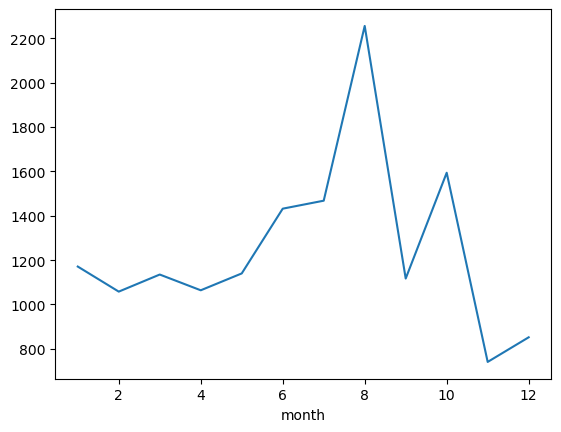

In [12]:
#Total number of misssed pick ups by month

filter_trash_report.groupby('month').size().plot();  #size() counts how many rows in each group

 * Create a plot showing the number of missed pickups per day.  
    

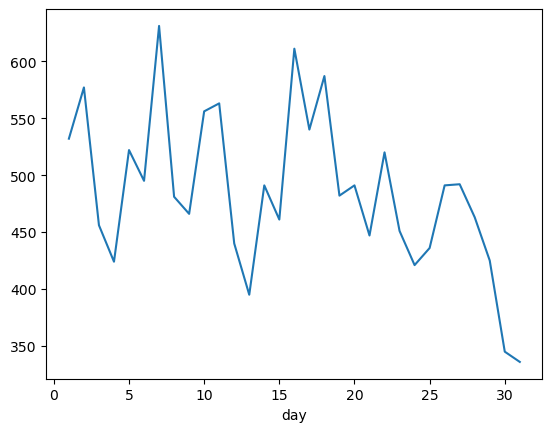

In [13]:
# Plot the number of missed pickups per day

filter_trash_report.groupby('day').size().plot();

* Compute a rolling 30-day average of daily missed pickups. Visualize your results with a line chart to see trends.

In [14]:
# Find out number of missed pick ups per Date and created new df
missed_per_day = filter_trash_report.groupby('Date Opened').size().reset_index()
missed_per_day.columns = ['Date Opened', 'num_missed_pickups']

# Convert datatype of Date Opened column to date time datatype
missed_per_day['Date Opened'] = pd.to_datetime(missed_per_day['Date Opened'])
missed_per_day.head()

,Date Opened,num_missed_pickups
0,2017-11-01,25
1,2017-11-02,29
2,2017-11-03,19
3,2017-11-05,2
4,2017-11-06,21


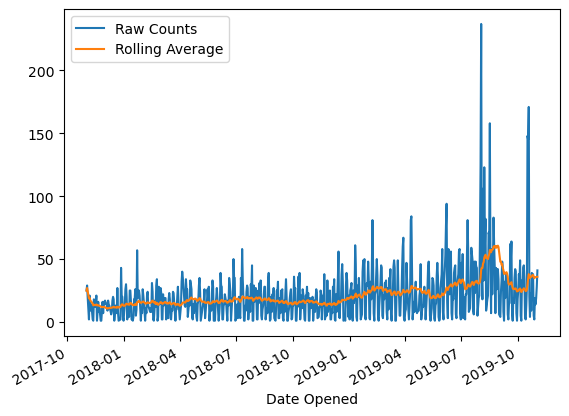

In [15]:
# Computing rolling 3o-day average of missed pickups
missed_per_day['rolling_30D'] = missed_per_day.rolling(window = '30D', on='Date Opened')['num_missed_pickups'].mean()

# Visualization of 30-day average of missed pickups
ax = missed_per_day.plot(x='Date Opened', y='num_missed_pickups', label= 'Raw Counts')
missed_per_day.plot(x='Date Opened', y='rolling_30D', label= 'Rolling Average', ax=ax);

In [16]:
missed_per_day.head()

,Date Opened,num_missed_pickups,rolling_30D
0,2017-11-01,25,25.000000
1,2017-11-02,29,27.000000
2,2017-11-03,19,24.333333
3,2017-11-05,2,18.750000
4,2017-11-06,21,19.200000


**Step 3: Main Task – 180-Day Rolling Fine Calculation**  
Metro Nashville charges fines for excessive missed trash pickups. It uses the following method to calculate the total fine:  A $1500 fine is charged for each missed pickup that is the third or subsequent one at the same address within a 180-day window. Multiple fines may apply to the same address.  
What is the total fine across all addresses? **Hint:** The rolling method can be use in combination with groupby.

In [17]:
filter_trash_report

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,State Plan Y,LONGITUDE,LATITUDE,year,month,day,day_of_week,address_clean
1,25274,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/Trash miss Tuesday.,4028 Clarksville Pike,37218.0,RED RIVER,4202,1.0,1721259.366,685444.7996,-86.838103,36.213470,2017,11,1,Wednesday,4028 clarksville pike
2,25276,2017-11-01,Trash - Curbside/Alley Missed Pickup,Curb/trash miss Tuesday.,6528 Thunderbird Dr,37209.0,RED RIVER,4205,20.0,1707026.753,659887.4716,-86.885562,36.142923,2017,11,1,Wednesday,6528 thunderbird dr
3,25307,2017-11-01,Trash - Curbside/Alley Missed Pickup,missed,2603 old matthews rd,37207.0,WASTE IND,2206,2.0,1735691.771,685027.2459,-86.789170,36.212652,2017,11,1,Wednesday,2603 old matthews rd
4,25312,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed the even side of the road.,604 croley dr,37209.0,RED RIVER,4203,20.0,1710185.772,664205.1011,-86.874995,36.154861,2017,11,1,Wednesday,604 croley dr
8,25330,2017-11-01,Trash - Curbside/Alley Missed Pickup,Missed.,4484 Lavergne Couchville Pike,37013.0,RED RIVER,4210,33.0,1794533.514,618749.3427,-86.588364,36.031728,2017,11,1,Wednesday,4484 lavergne couchville pike
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20221,267125,2019-11-01,Trash - Curbside/Alley Missed Pickup,MISSED...NEIGHBORS MISSED,2731 Murfreesboro Pike,37013.0,RED RIVER,4502,32.0,1781137.263,632448.5511,-86.633970,36.069130,2019,11,1,Friday,2731 murfreesboro pike
20222,267126,2019-11-01,Trash - Curbside/Alley Missed Pickup,entire alley,"1621 Long Ave, Nashville, TN 37206, United States",37206.0,METRO,9508,6.0,1749711.399,669201.6016,-86.741242,36.169482,2019,11,1,Friday,1621 long ave
20223,267130,2019-11-01,Trash - Curbside/Alley Missed Pickup,missed several,"2943 Windemere Cir, Nashville, TN 37214, Unite...",37214.0,RED RIVER,1502,15.0,1770293.388,674936.3038,-86.671647,36.185643,2019,11,1,Friday,2943 windemere cir
20224,267134,2019-11-01,Trash - Curbside/Alley Missed Pickup,Caller stated trash was missed & were only pic...,"3325 Murfreesboro Pike, Nashville, TN 37013, U...",37013.0,RED RIVER,4502,32.0,1785224.998,627146.4002,-86.620025,36.054637,2019,11,1,Friday,3325 murfreesboro pike


In [24]:
filter_trash_report['Incident Address'] = (
     filter_trash_report['Incident Address']
    .str.lower()
    .str.strip()
    .str.split(",", expand=True)[0]
)

/var/folders/n1/v3s1h2t95hb_nmn96mg49sbm0000gn/T/ipykernel_42694/1656732817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_trash_report['Incident Address'] = (


In [25]:
# Drop NaN values of "Incident Address" , sort values and copy the df into a new df
metro_report = filter_trash_report.dropna(subset=["Incident Address"]).sort_values(["Incident Address", "Date Opened"]).copy()
metro_report.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15020 entries, 4477 to 891
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Request Number    15020 non-null  int64         
 1   Date Opened       15020 non-null  datetime64[ns]
 2   Request           15020 non-null  object        
 3   Description       14991 non-null  object        
 4   Incident Address  15020 non-null  object        
 5   Zip Code          14970 non-null  float64       
 6   Trash Hauler      14420 non-null  object        
 7   Trash Route       14403 non-null  object        
 8   Council District  14989 non-null  float64       
 9   State Plan X      15005 non-null  float64       
 10  State Plan Y      15005 non-null  float64       
 11  LONGITUDE         15005 non-null  float64       
 12  LATITUDE          15005 non-null  float64       
 13  year              15020 non-null  int32         
 14  month             15020 no

In [26]:
metro_fines = (
    metro_report 
#Group the DataFrame by each unique incident address
    .groupby('Incident Address')
#Apply a rolling window of 180 days based on the 'Date Opened' column
# For each row, it will check previous 180 days and include all rows in that window
    .rolling('180D', on = 'Date Opened') 
    .count()
    .reset_index()
)
#Filtered the df for only required columns
filtered_metro_fines=metro_fines[['Incident Address','Date Opened', 'Request']]
#Rename the column
filtered_metro_fines=filtered_metro_fines.rename(columns = {'Request':'count_180d'})
filtered_metro_fines.head()  #Got 15020Rows

,Incident Address,Date Opened,count_180d
0,1 belle forrest ave c,2018-06-29,1.0
1,10 belle forrest ave,2018-07-02,1.0
2,100 bluefield square,2019-03-15,1.0
3,100 braxton hill ct,2018-03-07,1.0
4,100 brook hollow rd,2018-12-05,1.0


In [36]:
# Convert 'count_180d'(float) column datatype to integer
filtered_metro_fines['count_180d'].astype(int)

#calculate the fines for missed pickups for more than two times
filtered_metro_fines['fine']=(filtered_metro_fines['count_180d']>=3) * 1500

#sum all the fines
total_fine = filtered_metro_fines['fine'].sum()
print(f'The total fine across all addresses is ${total_fine:,.2f}.')

The total fine across all addresses is $2,142,000.00.


**Step 4: Bonus Questions**

* What other types of complaints are there?

In [28]:
#Other types of Compaints
other_complaints= trash_report[~trash_report['Request'].str.contains('Trash - Curbside/Alley Missed Pickup')]
other_complaints.head(2)
other_complaints['Request'].unique().tolist()

['Trash - Backdoor', 'Trash Collection Complaint', 'Damage to Property']

* Are there any geospatial patterns?

In [136]:
filtered_metro_fines

,Incident Address,Date Opened,count_180d,fine,row_id
0,1 belle forrest ave c,2018-06-29,1.0,0,0
1,10 belle forrest ave,2018-07-02,1.0,0,1
2,100 bluefield square,2019-03-15,1.0,0,2
3,100 braxton hill ct,2018-03-07,1.0,0,3
4,100 brook hollow rd,2018-12-05,1.0,0,4
...,...,...,...,...,...
15015,tusculum rd,2019-07-18,1.0,0,15015
15016,tusculum rd,2019-08-01,2.0,0,15016
15017,tusculum rd,2019-08-02,3.0,1500,15017
15018,westboro dr,2019-08-15,1.0,0,15018


In [137]:
unique_fines = filtered_metro_fines.groupby(['Date Opened','Incident Address'],as_index=False)[['count_180d','fine']].max()

In [138]:
#merge dataframes
merged_report = metro_report.merge(unique_fines, how='left',on = ['Date Opened','Incident Address'])
merged_report

,Request Number,Date Opened,Request,Description,Incident Address,Zip Code,Trash Hauler,Trash Route,Council District,State Plan X,...,LONGITUDE,LATITUDE,year,month,day,day_of_week,address_clean,row_id,count_180d,fine
0,79395,2018-06-29,Trash - Curbside/Alley Missed Pickup,the entire street was missed,1 belle forrest ave c,37206.0,METRO,9502,7.0,1751942.483,...,-86.733905,36.193409,2018,6,29,Friday,1 belle forrest ave c,4477,1.0,0
1,79884,2018-07-02,Trash - Curbside/Alley Missed Pickup,Missed entire street- carts are curbside in fr...,10 belle forrest ave,37206.0,METRO,9502,7.0,1751718.498,...,-86.734668,36.193906,2018,7,2,Monday,10 belle forrest ave,4511,1.0,0
2,155122,2019-03-15,Trash - Curbside/Alley Missed Pickup,MISS,100 bluefield square,37214.0,RED RIVER,1505,15.0,1770430.599,...,-86.670995,36.163465,2019,3,15,Friday,100 bluefield square,10929,1.0,0
3,52252,2018-03-07,Trash - Curbside/Alley Missed Pickup,Missed- trash,100 braxton hill ct,37204.0,RED RIVER,3302S,25.0,1733780.504,...,-86.794435,36.091422,2018,3,7,Wednesday,100 braxton hill ct,2214,1.0,0
4,121431,2018-12-05,Trash - Curbside/Alley Missed Pickup,Missed- trash,100 brook hollow rd,37205.0,RED RIVER,1303,23.0,1708042.849,...,-86.881589,36.095062,2018,12,5,Wednesday,100 brook hollow rd,7727,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15015,217242,2019-07-18,Trash - Curbside/Alley Missed Pickup,Trash was picked up on one side of the street ...,tusculum rd,37013.0,NaN,NaN,30.0,1762129.879,...,-86.698171,36.056113,2019,7,18,Thursday,tusculum rd,15187,1.0,0
15016,224234,2019-08-01,Trash - Curbside/Alley Missed Pickup,Trash carts were placed at the road before 7:0...,tusculum rd,37013.0,NaN,NaN,30.0,1762129.879,...,-86.698171,36.056113,2019,8,1,Thursday,tusculum rd,15832,2.0,0
15017,224685,2019-08-02,Trash - Curbside/Alley Missed Pickup,Trash is scheduled for collection on Thursday....,tusculum rd,37013.0,NaN,NaN,30.0,1762129.879,...,-86.698171,36.056113,2019,8,2,Friday,tusculum rd,15971,3.0,1500
15018,232129,2019-08-15,Trash - Curbside/Alley Missed Pickup,miss,westboro dr,37209.0,RED RIVER,4203,20.0,1710105.753,...,-86.875229,36.151493,2019,8,15,Thursday,westboro dr,16817,1.0,0


In [139]:
merged_report.duplicated().sum()

np.int64(0)

In [140]:
merged_report[['LONGITUDE','LATITUDE']].describe()

,LONGITUDE,LATITUDE
count,15005.000000,15005.000000
mean,-86.699817,36.117761
std,2.125488,0.887550
min,-87.031386,0.000322
25%,-86.812394,36.087264
50%,-86.747816,36.135421
75%,-86.704367,36.187008
max,-0.000798,36.466974


In [141]:
merged_report.shape

(15020, 21)

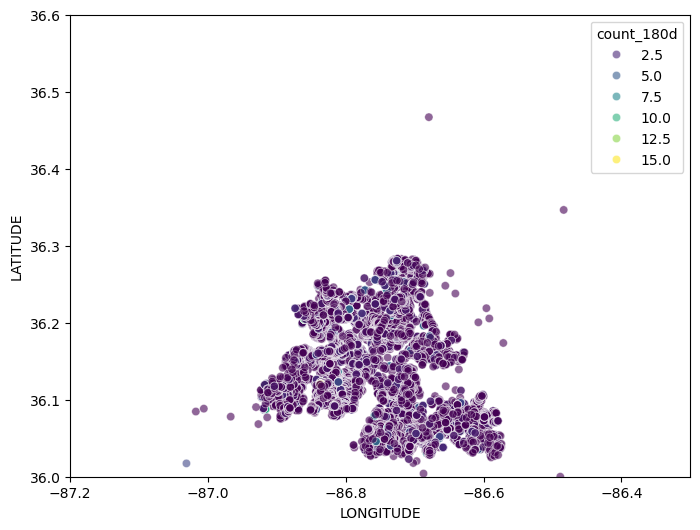

In [142]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=merged_report, x='LONGITUDE',y='LATITUDE', hue= 'count_180d' , palette='viridis',alpha=0.6)
plt.xlim(-87.2,-86.3)
plt.ylim(36.0,36.6)
plt.show()


* How do metro crews compare to the contractor's performance?

In [143]:
# Count the Metro and contractors incidents
metro = merged_report.copy()
metro['Trash Hauler'] = metro['Trash Hauler'].str.upper()
metro.groupby('Trash Hauler')['Incident Address'].count()

Trash Hauler
METRO         2687
RED RIVER    10714
WASTE IND     1019
Name: Incident Address, dtype: int64

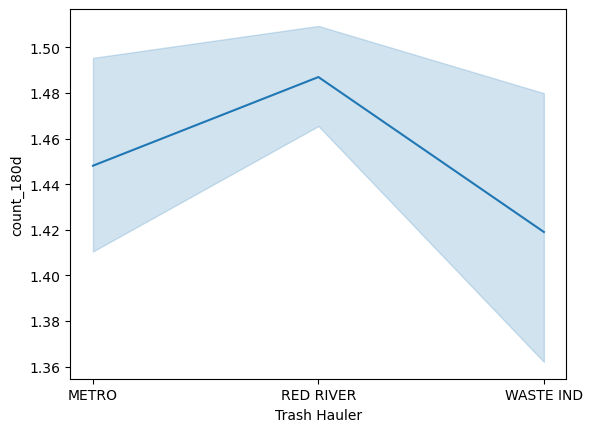

In [144]:
sns.lineplot(data=metro,x='Trash Hauler', y = 'count_180d');

In [145]:
#Compare the 180D mean values of trash hauler
metro.groupby('Trash Hauler')['count_180d'].mean()

Trash Hauler
METRO        1.448083
RED RIVER    1.486933
WASTE IND    1.419038
Name: count_180d, dtype: float64

* How much does each trash hauler owe?

In [146]:
#Each Trash Hauler sum of fines
metro.groupby('Trash Hauler')['fine'].sum()

Trash Hauler
METRO         352500
RED RIVER    1581000
WASTE IND     126000
Name: fine, dtype: int64

* What were the total missed pickup by route?

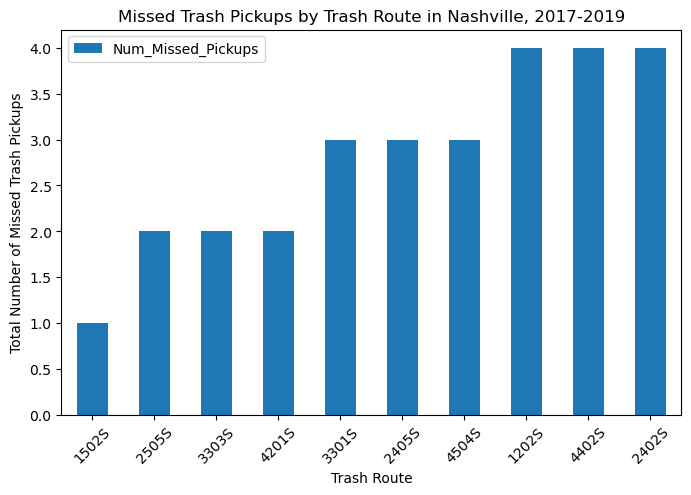

In [147]:
#Total missed pickups by route
missed_pickups_by_route = metro.groupby('Trash Route').size().reset_index(name = 'Num_Missed_Pickups')
missed_pickups_by_route.columns = ['Trash Route', 'Num_Missed_Pickups']
missed_pickups_by_route = missed_pickups_by_route.sort_values(by='Num_Missed_Pickups').head(10)
missed_pickups_by_route.plot(kind='bar', x='Trash Route', y='Num_Missed_Pickups', rot=45, figsize=(8, 5))
plt.title('Missed Trash Pickups by Trash Route in Nashville, 2017-2019')
plt.xlabel('Trash Route')
plt.ylabel('Total Number of Missed Trash Pickups')
plt.show()